In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In this notebook, we explore the method of using CNN networks for text classification. A companion notebook exploring RNN, LSTM and GRU-based networks can be found at:

https://www.kaggle.com/code/lorresprz/covid19-tweet-analysis-rnn-lstm-others

While CNN networks are widely believed to be restricted to the application of computer vision, they can be quite effective in dealing with time series or text sequence data using the operation of 1D convolution. The performance of CNN networks for text processing or time series analysis can be comparable to their RNN counterparts in some cases. 

Essentially, 1D convolution can pick up patterns in the series data as effectively as 2D convolution can in image data. 

# Loading data

In [2]:
df_train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding = 'latin')
df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding = 'latin')

In [3]:
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Text(0.5, 1.0, 'Distribution of sentiment in training data')

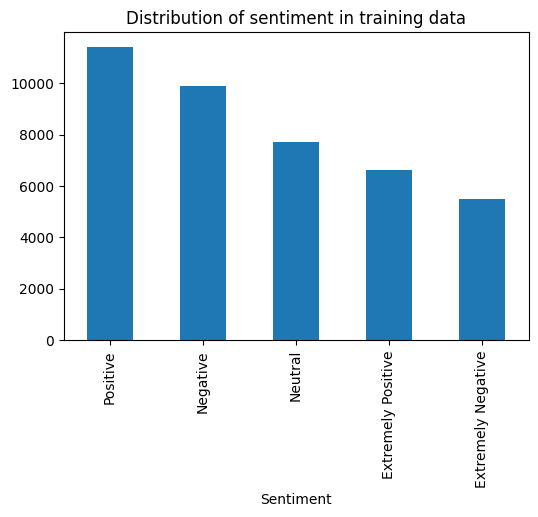

In [4]:
plt.figure(figsize = (6,4))
df_train.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in training data')

# Tokenizing text

In [5]:
x = df_train['OriginalTweet']
y = df_train['Sentiment']

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
import nltk
from nltk.corpus import stopwords

In [8]:
#Cleaning the texts and getting rid of unclear symbols or characters
#This function is from: https://www.kaggle.com/code/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc
import re
def text_cleaner(tweet):   
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)  
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])   
    return tweet

stop_words = stopwords.words('english')

X_c = x.apply(text_cleaner)
X_c.head()


0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[18]))
print("\nAfter tokenizing :\n{}".format(X[18]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[18]))

Vocabulary size: 36117

Example:

Sentence:
Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries ÂAs COVID- spread, weÂve seen significant increase people shopping online groceries,Â spokeswoman said statement. ÂToday resulted systems impact affecting ...

After tokenizing :
[423, 13610, 13611, 478, 742, 510, 7, 614, 11240, 1, 92, 1936, 262, 1200, 218, 8, 12, 13, 266, 245, 13612, 143, 1740, 9764, 3690, 1651, 107, 1303]

After padding :
[  423 13610 13611   478   742   510     7   614 11240     1    92  1936
   262  1200   218     8    12    13   266   245 13612   143  1740  9764
  3690  1651   107  1303     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [10]:
sentiments = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
y = y.map(sentiments)
labels = ['Negative', 'Neutral', 'Positive']

In [11]:
X_test = df_test['OriginalTweet'].copy()
y_test = df_test['Sentiment'].copy()

X_test = X_test.apply(text_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

# Generic function for model training

In [12]:
def training_plotting_predicting(model, eps, bs, model_name):

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy'])
            
    history = model.fit(X, y, epochs=eps, 
                        validation_split=0.15, batch_size=bs,
                        callbacks = [callback])
    
    hist_model = pd.DataFrame(history.history)
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    CNN_loss, CNN_acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(CNN_loss))
    print('Test Accuracy: {}'.format(CNN_acc))
    
    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix of ' + model_name)
    plt.show()
    
    return CNN_acc, cm

# CNN model 1: 3 Conv1D blocks

A brief overview of the architecture and input/output shapes at various stages in the CNN model:

- Input shape of the series is ($T,1)$
- After the Embedding layer with dimension $D$, the output is $(T, D)$

- After the first Conv1D with filter number $F_1$  and kernel size K, the output is ($T-K+1, F_1)$
- After the next MaxPooling1D layer with size $M_1$, the output is $$((T - K + 1)/M_1, F_1)$$

- The formula for the next convolution block is the same. 
- At the end of the convolution block, add a Flatten() or a GlobalMaxPooling1D() layer, which reduces the first dimension to 1. Assuming that there is only 1 convolution block with the last output dimension as above, after the GlobalMaxPooling1D() layer, the output is: $(1, F_1)$



In [13]:
embedding_dim = 16
#Input size is 54x1
i= layer.Input(shape=(X.shape[1],),)
x = layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1])(i)

#Output of this next layer is (54-3+1,32) = (52,32)
x = layer.Conv1D(32, 3, activation='relu')(x)
#Output of this next layer is (52/2, 32) = (26,32)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (26-3+1, 64) = (24,64)
x = layer.Conv1D(64, 3, activation='relu')(x)
#Output of this next layer is (24/2, 64) = (12,64)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (12-3+1,128) = (10,128) 
x = layer.Conv1D(128, 3, activation='relu')(x)
#Output of this next layer is (10/2,128) = (5,128)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (1,128) 
x = layer.GlobalMaxPooling1D()(x)
outputs = layer.Dense(3, activation='softmax')(x)
model_1 = tf.keras.Model(i, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding (Embedding)       (None, 54, 16)            577872    
                                                                 
 conv1d (Conv1D)             (None, 52, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 64)           0         
 1D)                                                         

Epoch 1/15
1094/1094 [==============================] - 41s 34ms/step - loss: 0.6259 - accuracy: 0.7404 - val_loss: 0.4064 - val_accuracy: 0.8654
Epoch 2/15
1094/1094 [==============================] - 9s 8ms/step - loss: 0.3220 - accuracy: 0.8967 - val_loss: 0.3840 - val_accuracy: 0.8741
Epoch 3/15
119/119 [==============================] - 0s 2ms/step
Test loss: 0.506710946559906
Test Accuracy: 0.8370195031166077


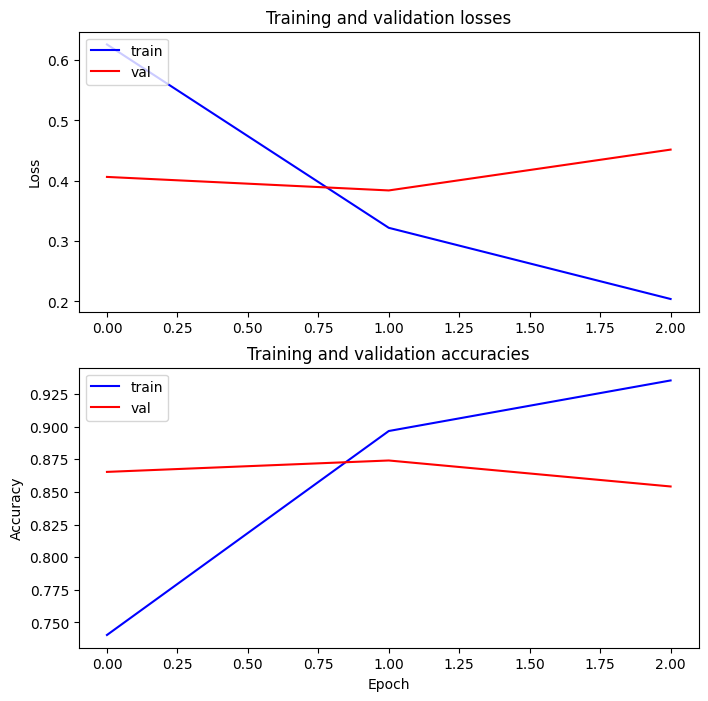

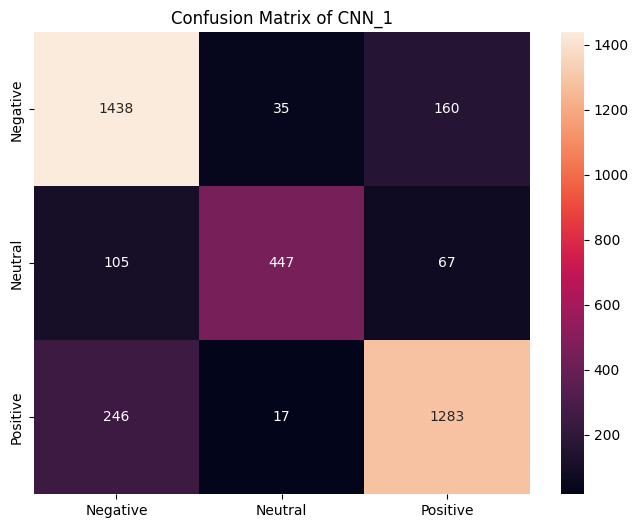

In [14]:
cnn1 = training_plotting_predicting(model_1, 15, 32, 'CNN_1')

The intended number of epochs is 15 (same as the RNN counterparts in the companion notebook), but after 2 epochs, the model starts to have its val_accuracy decrease and its val_loss increase. After 2 epochs, the accuracy already surpasses the RNN models in other notebook. 

# CNN model 2: 2 Conv1D blocks

This CNN model is a simpler version of the one above, with one Conv1D+MaxPooling1D block less

In [15]:
embedding_dim = 16
#Input size is 54x1
i= layer.Input(shape=(X.shape[1],),)
x = layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1])(i)

#Output of this next layer is (54-3+1,32) = (52,32)
x = layer.Conv1D(32, 3, activation='relu')(x)
#Output of this next layer is (52/2, 32) = (26,32)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (26-3+1, 64) = (24,64)
x = layer.Conv1D(64, 3, activation='relu')(x)
#Output of this next layer is (24/2, 64) = (12,64)
x = layer.MaxPooling1D(2)(x)

#Output of this next layer is (64) 
x = layer.GlobalMaxPooling1D()(x)
outputs = layer.Dense(3, activation='softmax')(x)
model_2 = tf.keras.Model(i, outputs)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 54, 16)            577872    
                                                                 
 conv1d_3 (Conv1D)           (None, 52, 32)            1568      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 26, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 64)            6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 12, 64)           0         
 1D)                                                       

Epoch 1/15
1094/1094 [==============================] - 28s 24ms/step - loss: 0.1407 - accuracy: 0.9566 - val_loss: 0.5464 - val_accuracy: 0.8448
Epoch 2/15
119/119 [==============================] - 0s 2ms/step
Test loss: 0.81099534034729
Test Accuracy: 0.8101632595062256


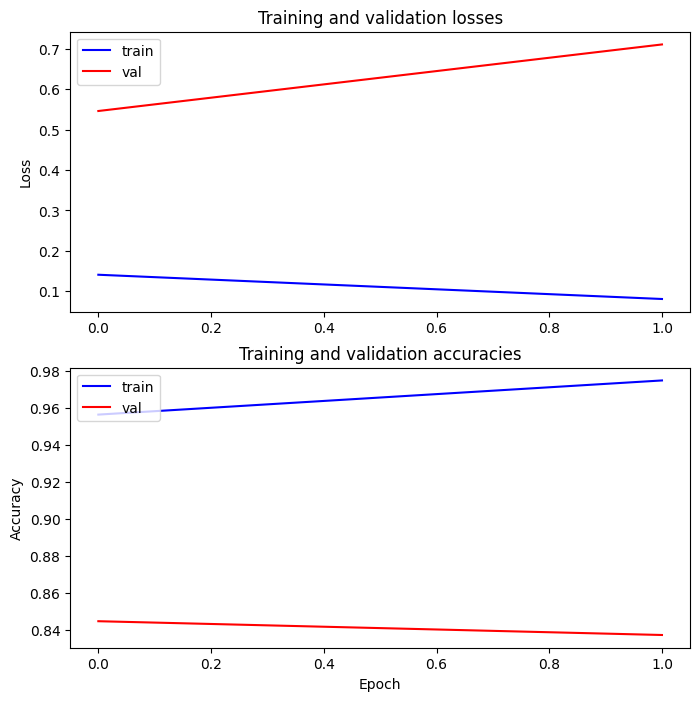

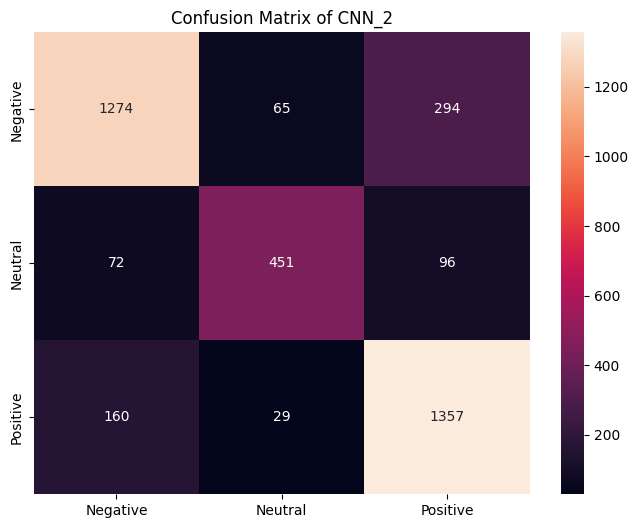

In [16]:
cnn2 = training_plotting_predicting(model_1, 15, 32, 'CNN_2')

# Comparison with recurrent type networks

In this section, we compare the accuracy of the CNN network with those explored in the companion notebook https://www.kaggle.com/code/lorresprz/covid19-tweet-analysis-rnn-lstm-others

The accuracy scores below are those obtained from the notebook above. 

In [17]:
model_RNN_acc = 0.828067421913147
model_LSTM_acc = 0.8006845712661743
model_GRU_acc = 0.8104265332221985
model_RNN_G_acc = 0.73854660987854
model_LSTM_G_acc = 0.7580305337905884
model_GRU_G_acc = 0.7472353577613831
model_bLSTM_G_acc = 0.7761979699134827

In [20]:
dc = {'Networks': ['CNN_1', 'CNN_2', 'RNN', 'LSTM', 'GRU', 'RNN_G', 'LSTM_G', 'bLSTM_G', 'GRU_G'], 
      'Accuracy':[cnn1[0], cnn2[0], model_RNN_acc, model_LSTM_acc, model_GRU_acc, model_RNN_G_acc, model_LSTM_G_acc,
                  model_bLSTM_G_acc,model_GRU_G_acc]}
dfc = pd.DataFrame(dc)
dfc2 = dfc.set_index('Networks')

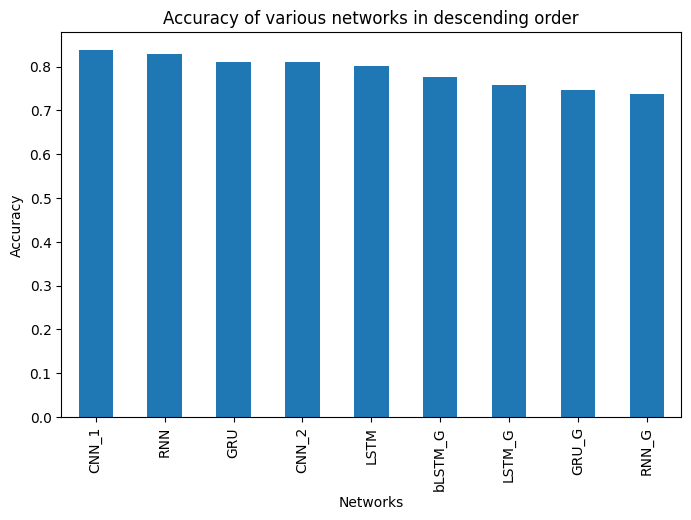

In [22]:
plt.figure(figsize =(8,5))
dfc2['Accuracy'].sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('Accuracy')
plt.title('Accuracy of various networks in descending order');

The performances of both CNN models are comparable to their recurrent counterparts and for the more complex CNN model, the performance is better than all recurrent models studied. 